# Predicting Churn - Desafio Data Science - Indicium

As I explained better about the problem in the EDA, here let's focus on the prediction model.

As we have to predict the variavle Exited(0 or 1), we are facing a **classification** problem. Where with the data, we will predict 0 if the customer will not leave the bank or 1 if the customer will leave the bank.


## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score

from lightgbm import LGBMClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import StratifiedKFold

import warnings
import joblib
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')

# Set random seed
SEED = 11

In [3]:
df = pd.read_csv('Abandono_clientes.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Feature Engineering


In [4]:
# Start droping columns that are not needed for the prediction
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [5]:
# Check for null values
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No null values found, that's good because we can use all the data for the prediction without worrying about missing values.


#### Encoding categorical variables

explciar importancia de encoding

In [6]:
# Converting Gender to binary
df['Male'] = df['Gender'].map({'Male': 1, 'Female': 0})
df.drop(columns=['Gender'], inplace=True)

# Making One Hot Encoding for the Geography column as it is a categorical variable
df = pd.get_dummies(df, columns=['Geography'], prefix='Geo', dtype=int)

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Geo_France,Geo_Germany,Geo_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,0,1


We can see that the Geography column was transformed into 3 new columns, one for each country. This is necessary because the models that understand only numerical values will not be able to understand the categorical variable so we use one hot encoding to transform it into numerical values.


### Splitting the data

Before split the data i want to clarify that after analyzing the correlation matrix and the charts of the variables (Present on the eda notebook) I decided to remove the feature HasCrCard because it has a very low correlation with the target variable and it chart shows that it doesn't have a significant difference between the two classes of the target variable. Futhermore i made some tests that i'm not gonna show here for th enotebook not get too big testing with logistic regression, random forest and decision tree, the accuracy was the same with and without this feature and its feature importance was very low in all three models. So our final dataset will be:

In [7]:
df.drop(columns=['HasCrCard']).head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,IsActiveMember,EstimatedSalary,Exited,Male,Geo_France,Geo_Germany,Geo_Spain
0,619,42,2,0.00,1,1,101348.88,1,0,1,0,0
1,608,41,1,83807.86,1,1,112542.58,0,0,0,0,1
2,502,42,8,159660.80,3,0,113931.57,1,0,1,0,0
3,699,39,1,0.00,2,0,93826.63,0,0,1,0,0
4,850,43,2,125510.82,1,1,79084.10,0,0,0,0,1


In [8]:
X = df.drop(columns=['Exited', 'HasCrCard'])
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

By splitting the data into training and testing sets, we can evaluate the model's performance on unseen data. This is crucial for assessing the model's generalization capabilities and ensuring it can make accurate predictions on new, unseen data. For this instance, we split on 8000 samples for training and 2000 samples for testing.

#### Talking about scaling
For tree-based models, scaling the data is not necessary. These models are not distance-based, so their performance and structure are unaffected by features being on different scales. In fact, scaling can even reduce the interpretability of tree-based models because the raw feature values often carry meaningful insights into splits and thresholds.

However, for other types of models, scaling is crucial. For example, in this case, the variables have different ranges: Age ranges from 18 to 92, while EstimatedSalary ranges from 11.58 to 199,992. If features are not on the same scale, it can introduce bias in distance-based models, such as k-Nearest Neighbors (k-NN), or hinder convergence in gradient-based models, such as logistic regression or neural networks. By scaling the data, we ensure that all features contribute equally, improving model performance and reliability.

But its timing is equally important. By splitting your dataset before scaling, you preserve the independence of the test set, prevent data leakage, and ensure accurate model evaluation. 

So we are gonna make a data non scaled for tree-based models and scaled for other models.


In [9]:
# Scaling the data for models that require it
scaler = StandardScaler()

numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

X_train_scaled = X_train.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])

X_test_scaled = X_test.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# Save the scaler
joblib.dump(scaler, 'scalers_n_models/standard_scaler.pkl');

## Testing models

I'm gonna test some models that are grouped as:
* Tree-based models
* Linear Models
* Clustering Models
* Neural Network

### Tree-based models

As we are dealing with a problem that business interpretability is important, we will start with tree-based models. These models are easy to interpret and can provide insights into feature importance, which can be valuable for understanding the factors that drive customer churn.

#### Decision Tree

As we need interpretabily but also a model with good performance, we will use the Decision Tree model. Lets make a grid search and cross validation to find the best hyperparameters for the model and a fine tuning with the best hyperparameters found.

In [10]:
dt_clf = DecisionTreeClassifier(random_state=SEED, max_depth=5)

We are gonna use GridSearch, a technique that allows us to find the best hyperparameters for a model by testing all possible combinations of hyperparameters in a grid. This is a computationally expensive process, but it ensures that we find the best hyperparameters for our model. 

Is worth to comment that the parameter max_depth is the maximum depth of the tree. A deeper tree can capture more information about the data, but it is also more likely to overfit. Beyond that, I put the max_depth = 5 because I want the power or interpretability of the decision tree, and as the tree gets deeper, it becomes more difficult to interpret, as it has more decision nodes and branches.

In [11]:
# Parameters for the Grid Search test and get the best parameters
initial_param_grid = {
    'min_samples_split': [2, 7, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

In [12]:
initial_search = GridSearchCV(
    dt_clf,
    param_grid=initial_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

initial_search.fit(X_train, y_train)

Fitting 7 folds for each of 120 candidates, totalling 840 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=11),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'min_samples_split': [2, 7, 10, 15, 20]},
             verbose=2)

In [13]:
# Retrieving the best parameters
best_min_samples_split = initial_search.best_params_['min_samples_split']
best_min_samples_leaf = initial_search.best_params_['min_samples_leaf']
best_max_features = initial_search.best_params_['max_features']
best_criterion = initial_search.best_params_['criterion']

Now that we have the best params for the model, we can make another grid search with cross validation with values around the best params to make a fine tuning to see if we can improve the model even more.

##### Fine Tuning

In [14]:
# Grid for fine tuning with the parameters around the best ones
fine_tuning_param_grid = {
    'min_samples_split': [
        best_min_samples_split - 2, best_min_samples_split - 1, best_min_samples_split,
        best_min_samples_split + 1, best_min_samples_split + 2],
    'min_samples_leaf': [
        best_min_samples_leaf - 2, best_min_samples_leaf - 1, best_min_samples_leaf,
        best_min_samples_leaf + 1, best_min_samples_leaf + 2],
    'max_features': [best_max_features],
    'criterion': [best_criterion]
}                          

# Removing any invalid parameters
fine_tuning_param_grid['min_samples_split'] = [i for i in fine_tuning_param_grid['min_samples_split'] if i > 1]

fine_tuning_param_grid['min_samples_leaf'] = [i for i in fine_tuning_param_grid['min_samples_leaf'] if i > 1]

In [15]:
fine_tuning_dt = GridSearchCV(
    dt_clf,
    param_grid=fine_tuning_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

fine_tuning_dt.fit(X_train, y_train)

Fitting 7 folds for each of 15 candidates, totalling 105 fits


GridSearchCV(cv=7,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=11),
             n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 5, 6, 7],
                         'min_samples_split': [2, 3, 4]},
             verbose=2)

In [16]:
# Get final cross-validation scores
final_cv_scores = cross_val_score(
    fine_tuning_dt.best_estimator_,
    X_train,
    y_train,
    cv=7,
    n_jobs=-1,
    scoring='accuracy'
)

print(f"Mean Cross-Validation accuracy Score: {final_cv_scores.mean():.2f}")

Mean Cross-Validation accuracy Score: 0.83


In [17]:
fine_tuning_dt.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_leaf=6, random_state=11)

In [18]:
# Printing metrics of our best model
y_pred = fine_tuning_dt.best_estimator_.predict(X_test)

dt_train_acc = fine_tuning_dt.best_estimator_.score(X_train, y_train)
dt_train_f1score = f1_score(y_train, fine_tuning_dt.best_estimator_.predict(X_train)) 
dt_test_acc = fine_tuning_dt.best_estimator_.score(X_test, y_test)
dt_test_f1score = f1_score(y_test, y_pred)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      1602
           1       0.76      0.26      0.38       398

    accuracy                           0.84      2000
   macro avg       0.80      0.62      0.64      2000
weighted avg       0.83      0.84      0.80      2000



The Decision Tree model achieved an accuracy of 0.84 on the test set. This is a good result, but we can still try to improve it by using other models. As expected, the precision and recall on class 1 are lower than class 0, which is common in imbalanced datasets. But as its represents the real world, if the make an upsample on class 1, we could loss the distribution of the data and the model could not perform well on real world data.

##### Feature Importance

In [19]:
dict_dt_importance = {k: v for k, v in zip(X.columns, fine_tuning_dt.best_estimator_.feature_importances_)}

dict_dt_importance_sort = sorted(dict_dt_importance.items(), key=lambda x: x[1], reverse=True)

for k, v in dict_dt_importance_sort[:5]:
    print(f"{k}: {v:.2f}")

Age: 0.37
NumOfProducts: 0.22
Geo_Germany: 0.17
Balance: 0.07
Male: 0.06


Feature importance is a valuable tool for understanding the factors that drive customer churn. By analyzing the importance of each feature, we can identify the key drivers of churn and take action to mitigate them. In this case, the model identified Age, NumOfProducts as the most important features for predicting churn. And as we saw in the EDA, these features have a significant impact on customer churn, for example:
* From the EDA notebook, we can see that customers in their late 40s and early 50s have higher churn rates
* Both younger and older customers show lower churn propensity
* About NumOfProducts, the bar plots in the EDA show that as customers purchase more products, their likelihood of churning decreases


Down below is a function that runs through the tree to return as the complete interpretability of why the model made the decision it made.

In [20]:
def extract_rules(sample_id, clf, df):

    # Get the feature values for the specific sample
    x_sample = df.iloc[sample_id]
    
    # Extract decision tree components
    feature = clf.tree_.feature      # Feature indices used for splits
    threshold = clf.tree_.threshold  # Threshold values for splits
    
    # Get the sequence of nodes visited for this sample
    node_indices = clf.decision_path([x_sample]).indices
    leaf_id = node_indices[-1]  # Final node (leaf) reached
    
    # Store the most restrictive condition for each feature
    conditions = {}
    
    # Print prediction context
    pred = clf.predict([x_sample])
    if pred == 0:
        print("This client will not leave the bank, because:")
    else:
        print("This client will leave the bank, because:")

    # Traverse the decision path and collect conditions
    for node_id in node_indices:
        if leaf_id == node_id:
            break
            
        feature_name = df.columns[feature[node_id]]
        current_value = x_sample[feature[node_id]]
        current_threshold = threshold[node_id]
        
        # Handle less than or equal to case
        if current_value <= current_threshold:
            threshold_sign = "<="
            # Update condition only if it's more restrictive (lower threshold)
            if feature_name not in conditions or current_threshold < conditions[feature_name][0]:
                conditions[feature_name] = (current_threshold, threshold_sign)
        # Handle greater than case
        else:
            threshold_sign = ">"
            # Update condition only if it's more restrictive (higher threshold)
            if feature_name not in conditions or current_threshold > conditions[feature_name][0]:
                conditions[feature_name] = (current_threshold, threshold_sign)

    # Format and print the conditions in a human-readable way
    for feature_name, (threshold_val, sign) in conditions.items():
        # Special handling for geographic features
        if feature_name.startswith('Geo_'):
            print(f"- Customer is from {feature_name[4:]}")
        # Special handling for active member status
        elif feature_name == 'IsActiveMember':
            print(f"- Customer {'is' if x_sample[feature_name] == 1 else 'is not'} an active member")
        # Special handling for gender
        elif feature_name == 'Male':
            print(f"- Customer is {'Male' if x_sample[feature_name] == 1 else 'Female'}")
        # Default handling for numerical features
        else:
            print(f"- {feature_name} {sign} {threshold_val:.2f}")

In [21]:
sample_idx = 8
extract_rules(sample_idx, fine_tuning_dt.best_estimator_, X_test.reset_index(drop=True))

print(f"\nReal label is: '{'will leave the bank' if y_test.iloc[sample_idx] else 'will not leave the bank'}' ")

This client will leave the bank, because:
- Customer is from Germany
- Customer is not an active member
- Age > 42.50
- NumOfProducts <= 1.50
- EstimatedSalary <= 72854.26

Real label is: 'will leave the bank' 


With this function we can see the path that the model took to make the decision, which is very important for the business to understand why the model made the decision it made.

In [22]:
# Save the model
joblib.dump(fine_tuning_dt.best_estimator_, 'scalers_n_models/decision_tree.pkl');

#### Lightgbm

Light Gradient Boosting Machine, is an advanced open-source machine learning framework developed by Microsoft. It uses decision tree algorithms as base learners in boosting. It is an ensemble method where models are trained sequentially, and each model attempts to correct the errors of its predecessor.

In [23]:
lgbm = LGBMClassifier(random_state=SEED, verbose=-1)

lgbm.fit(X_train, y_train)

lgbm_train_acc = lgbm.score(X_train, y_train)
lgbm_train_f1score = f1_score(y_train, lgbm.predict(X_train))
lgbm_test_acc = lgbm.score(X_test, y_test)
lgbm_test_f1score = f1_score(y_test, lgbm.predict(X_test))

y_pred = lgbm.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1602
           1       0.72      0.53      0.61       398

    accuracy                           0.87      2000
   macro avg       0.81      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



In [24]:
# Save the model
joblib.dump(lgbm, 'scalers_n_models/lightgbm.pkl'); 

As we can see, the accuracy of the LightGBM model is 0.87, which is higher than the Decision Tree model. And the precision and recall of class 1 are also higher than the Decision Tree model. This is good because we have to predict well the customers who will leave the bank, so we can take action to prevent it. But as tradeoff, we don't have the same interpretability as the Decision Tree model.

### Linear Models

These type of models uses a linear combination of input features to make a decision about class membership. It determines a decision boundary in the feature space, which is a hyperplane that separates the classes. For two features this boundary is a straight line. For three features, it's a plane, and so on. But in the most cases, the data is not linearly separable, so these class of models are not the best choice for these kind of problem.

#### Logistic Regression

Logistic regression is a linear model that uses the logistic function to model the probability that a given input sample belongs to a particular class. It is widely used for binary classification problems, where the goal is to predict the probability that an input sample belongs to one of two classes. But this model is sensitive of features with different scales, so we have to scale the data before using it.

In [25]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000)

In [26]:
# Let's use here the same strategy from the Decision Tree,
# using GridSearchCV to get the best parameters
initial_param_grid = {
    'C': np.logspace(-4, 4, 15),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

In [27]:
log_reg_cv = GridSearchCV(
    log_reg,
    param_grid=initial_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

log_reg_cv.fit(X_train_scaled, y_train)

Fitting 7 folds for each of 120 candidates, totalling 840 fits


GridSearchCV(cv=7, estimator=LogisticRegression(max_iter=1000, random_state=11),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 3.72759372e-04, 1.38949549e-03, 5.17947468e-03,
       1.93069773e-02, 7.19685673e-02, 2.68269580e-01, 1.00000000e+00,
       3.72759372e+00, 1.38949549e+01, 5.17947468e+01, 1.93069773e+02,
       7.19685673e+02, 2.68269580e+03, 1.00000000e+04]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             verbose=2)

In [28]:
# Printing metrics of our best model
y_pred = log_reg_cv.best_estimator_.predict(X_test_scaled)

log_reg_train_acc = log_reg_cv.best_estimator_.score(X_train_scaled, y_train)
log_reg_train_f1score = f1_score(y_train, log_reg_cv.best_estimator_.predict(X_train_scaled))
log_reg_test_acc = log_reg_cv.best_estimator_.score(X_test_scaled, y_test)
log_reg_test_f1score = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1602
           1       0.59      0.22      0.32       398

    accuracy                           0.81      2000
   macro avg       0.71      0.59      0.60      2000
weighted avg       0.78      0.81      0.78      2000



The model has an accuracy of 0.81, which is lower than the Decision Tree and LightGBM models. The precision and recall of class 1 are also lower than the Decision Tree and LightGBM models. This is not good because we have to predict well the customers who will leave the bank, so we can take action to prevent it.

In [29]:
# Save the model
joblib.dump(log_reg_cv.best_estimator_, 'scalers_n_models/logistic_regression.pkl');

### Clustering Models

Is a family of models that make a process of grouping data points into clusters based on their similarity or proximity in a feature space. The goal is to identify natural groupings within the data so that points in the same cluster are more similar to each other than to those in other clusters.


#### KNN (K-Nearest Neighbors)

KNN is a simple and versatile algorithm that can be used for both classification and regression tasks. It operates based on the principle of proximity, assigning a label or value to a query point based on the data points nearest to it in the feature space.

In [30]:
knn = KNeighborsClassifier()

In [31]:
initial_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [3, 4]  # Only for minkowski, p=1 is manhattan, p=2 is euclidean  
}

In [32]:
knn_cv = GridSearchCV(
    knn,
    param_grid=initial_param_grid,
    cv=7,
    n_jobs=-1,
    verbose=2
)

knn_cv.fit(X_train_scaled, y_train)

Fitting 7 folds for each of 84 candidates, totalling 588 fits


GridSearchCV(cv=7, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'p': [3, 4],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [33]:
# Printing metrics of our best model
y_pred = knn_cv.best_estimator_.predict(X_test_scaled)

knn_train_acc = knn_cv.best_estimator_.score(X_train_scaled, y_train)
knn_train_f1score = f1_score(y_train, knn_cv.best_estimator_.predict(X_train_scaled))
knn_test_acc = knn_cv.best_estimator_.score(X_test_scaled, y_test)
knn_test_f1score = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1602
           1       0.71      0.44      0.54       398

    accuracy                           0.85      2000
   macro avg       0.79      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [34]:
# Save the model
joblib.dump(knn_cv.best_estimator_, 'scalers_n_models/knn.pkl');

This model has an accuracy of 0.85, which is not bad, but we had models with higher accuracy. The precision and recall of class 1 are also lower than other models. And we have models with more interpretability.

### Neural Network

FALAR SPBRE NNN

In [35]:
def create_model(input_dim, learning_rate, hidden_layers):
    """
    Create a neural network model with specified hyperparameters
    """
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_layers[0], input_dim=input_dim, activation='relu'))
    model.add(Dropout(.25))
    
    # Hidden layers
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(.25))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy', F1Score()])
    
    return model

In [39]:
model = create_model(input_dim=X_train_scaled.shape[1], learning_rate=0.001, hidden_layers=[64, 32, 16, 8])

Epoch 1/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7592 - f1_score: 0.3346 - loss: 0.5589 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.4268
Epoch 2/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7904 - f1_score: 0.3462 - loss: 0.4619 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.4130
Epoch 3/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.7955 - f1_score: 0.3396 - loss: 0.4384 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.3984
Epoch 4/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7934 - f1_score: 0.3420 - loss: 0.4365 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.3890
Epoch 5/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7960 - f1_score: 0.3389 - loss: 0.4098 - val_accuracy: 0.8010 - val_f1_score: 0.3319 - val_loss: 0.3856
Epoch 6/500
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.8009 - f1_score: 0.3483 - loss: 0.4169 - val_accuracy: 0.8520 - val_f1_sco

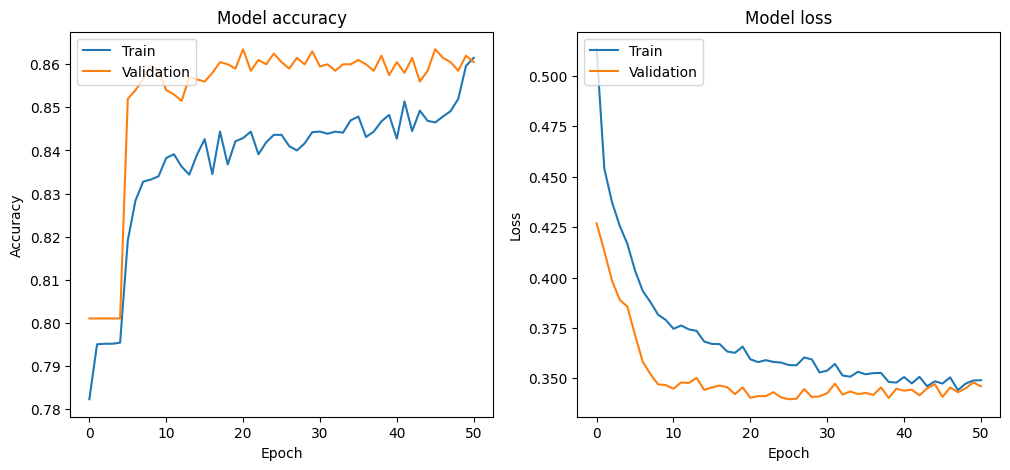

In [40]:
# Assuming the model training history is stored in a variable named 'history'
history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[EarlyStopping(patience=25)], verbose=1)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
y_pred = model.predict(X_test_scaled)

# Convert the probabilities to binary
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))

f1_score(y_test, y_pred)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      1602
           1       0.71      0.50      0.59       398

    accuracy                           0.86      2000
   macro avg       0.80      0.73      0.75      2000
weighted avg       0.85      0.86      0.85      2000



np.float64(0.5878877400295421)

In [43]:
# Save the model
model.save('scalers_n_models/neural_network_model.keras')